# Telco Customer Churn Project

## Introduction
Customer churn — the phenomenon of customers discontinuing their service — is a significant concern for subscription-based businesses like telecom providers. Reducing churn not only preserves revenue, but also lowers customer acquisition costs, making it a critical business priority.

In this project, I analyze a publicly available Telco Customer Churn dataset from Kaggle. The dataset contains information about a telecommunications company's customers, including demographics, account information, services used, and whether or not the customer has churned.

### Project Goals
The main objectives of this analysis are:
1. **Predict Customer Churn**: Build machine learning models to identify customers likely to cancel their service.

2. **Understand Churn Drivers**: Use interpretability techniques like SHAP and feature importance to understand what factors contribute most to churn.

3. **Generate Business Insights**: Provide actionable recommendations based on the data to help reduce churn and improve customer retention.

### Dataset Overview
The dataset includes the following types of features:
* Customer Demographics: Gender, senior citizen status, partner and dependents
* Account Information: Tenure, contract type, payment method, charges
* Services Subscribed: Internet service, phone service, streaming services, tech support, etc.
* Churn Label: Indicates whether the customer has left the company (target variable)

I handle preprocessing (e.g., encoding categorical variables, dealing with missing data), build and compare several classification models, and use visual tools to interpret results and support strategic business decisions.

## Import Files and Libraries

In [69]:
# Import necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# Import necessary files
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Define the file path
file_path = "/kaggle/input/telcocleaned/telcoCleaned.xls"

# Read the Excel file
df = pd.read_excel(file_path)

/kaggle/input/telcocleaned/telcoCleaned.xls
/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [70]:
df.head()

,customerID,gender,SeniorCitizen,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,StreamingMovies,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Partner,Dependents,PhoneService,PaperlessBilling,Churn
0,0002-ORFBO,Female,0,9,No,DSL,No,Yes,No,Yes,...,No,One year,Mailed check,65.599998,593.299988,-1,-1,-1,-1,0
1,0003-MKNFE,Male,0,9,Yes,DSL,No,No,No,No,...,Yes,Month-to-month,Mailed check,59.900002,542.400024,0,0,-1,0,0
2,0004-TLHLJ,Male,0,4,No,Fiber optic,No,No,Yes,No,...,No,Month-to-month,Electronic check,73.900002,280.850006,0,0,-1,-1,-1
3,0011-IGKFF,Male,-1,13,No,Fiber optic,No,Yes,Yes,No,...,Yes,Month-to-month,Electronic check,98.000000,1237.849976,-1,0,-1,-1,-1
4,0013-EXCHZ,Female,-1,3,No,Fiber optic,No,No,No,Yes,...,No,Month-to-month,Mailed check,83.900002,267.399994,-1,0,-1,-1,-1


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   tenure            7032 non-null   int64  
 4   MultipleLines     7032 non-null   object 
 5   InternetService   7032 non-null   object 
 6   OnlineSecurity    7032 non-null   object 
 7   OnlineBackup      7032 non-null   object 
 8   DeviceProtection  7032 non-null   object 
 9   TechSupport       7032 non-null   object 
 10  StreamingTV       7032 non-null   object 
 11  StreamingMovies   7032 non-null   object 
 12  Contract          7032 non-null   object 
 13  PaymentMethod     7032 non-null   object 
 14  MonthlyCharges    7032 non-null   float64
 15  TotalCharges      7032 non-null   float64
 16  Partner           7032 non-null   int64  


## Data Cleaning & Feature Engineering

Before importing the dataset into Kaggle, I performed data cleaning in SQL Server to ensure consistency and accuracy. The key steps included:

1. **Removed Duplicates**:
* Eliminated duplicate rows based on customerID.

2. **Standardized Data**:
* Verified categorical and binary columns had expected values (e.g., no typos or inconsistencies).
* Converted SeniorCitizen from INT to BIT to properly reflect its binary nature.
* Converted binary columns (Partner, Dependents, PhoneService, PaperlessBilling, Churn) from NVARCHAR to BIT for efficiency.

3. **Handled Missing Values**:
* Removed rows with NULL or blank values in critical fields like customerID, gender, tenure, Churn, MonthlyCharges, and TotalCharges.

This cleaned dataset was then exported to Kaggle for further analysis and model building.

The following is the SQL for data cleaning done in SSMS:

```
-- 1. Remove duplicates
DELETE T
FROM
(
SELECT *, 
DupRank = ROW_NUMBER() OVER (
			  PARTITION BY customerID
			  ORDER BY tenure
			)
FROM customerChurn_staging
) AS T
WHERE DupRank > 1;

SELECT * 
FROM customerChurn_staging;

-- 2. Standardize data
-- Checking to see the categorical or binary columns have the correct expected of distinct values
-- Partner, Dependents, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, Churn

SELECT DISTINCT Churn
FROM customerChurn_staging;

-- They have the expected values (no typos or alternative values) so no corrections needed

-- Types: SeniorCitizen is a binary value (0 or 1) to indicate whether the customer falls into that category. Currently it is stored as an integer.
-- I will be converting it into a BIT type
ALTER TABLE customerChurn_staging
ALTER COLUMN SeniorCitizen BIT;

-- The following columns are binary values (either Yes or No). Currently they are stored as a nvarchar: Partner, Dependents, PhoneService, PaperlessBilling, Churn
-- I will be converting them into a BIT type. I will avoid direct conversions as that is not supported in SQL Server
-- 1) Add new BIT columns
ALTER TABLE customerChurn_staging ADD Partner_Bit BIT;
ALTER TABLE customerChurn_staging ADD Dependents_Bit BIT;
ALTER TABLE customerChurn_staging ADD PhoneService_Bit BIT;
ALTER TABLE customerChurn_staging ADD PaperlessBilling_Bit BIT;
ALTER TABLE customerChurn_staging ADD Churn_Bit BIT;

-- 2) Update BIT columns: 'Yes' -> 1, 'No' -> 0
UPDATE customerChurn_staging
SET Partner_Bit = CASE WHEN Partner = 'Yes' THEN 1 ELSE 0 END,
    Dependents_Bit = CASE WHEN Dependents = 'Yes' THEN 1 ELSE 0 END,
    PhoneService_Bit = CASE WHEN PhoneService = 'Yes' THEN 1 ELSE 0 END,
    PaperlessBilling_Bit = CASE WHEN PaperlessBilling = 'Yes' THEN 1 ELSE 0 END,
    Churn_Bit = CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END;

-- 3) Drop old NVARCHAR columns
ALTER TABLE customerChurn_staging DROP COLUMN Partner;
ALTER TABLE customerChurn_staging DROP COLUMN Dependents;
ALTER TABLE customerChurn_staging DROP COLUMN PhoneService;
ALTER TABLE customerChurn_staging DROP COLUMN PaperlessBilling;
ALTER TABLE customerChurn_staging DROP COLUMN Churn;

-- 4) Rename new BIT columns to match original names
EXEC sp_rename 'customerChurn_staging.Partner_Bit', 'Partner', 'COLUMN';
EXEC sp_rename 'customerChurn_staging.Dependents_Bit', 'Dependents', 'COLUMN';
EXEC sp_rename 'customerChurn_staging.PhoneService_Bit', 'PhoneService', 'COLUMN';
EXEC sp_rename 'customerChurn_staging.PaperlessBilling_Bit', 'PaperlessBilling', 'COLUMN';
EXEC sp_rename 'customerChurn_staging.Churn_Bit', 'Churn', 'COLUMN';

SELECT *
FROM customerChurn_staging;

-- 3. Filter out null/blank rows
DELETE
FROM customerChurn_staging
WHERE ((customerID IS NULL OR customerID = '') OR (gender IS NULL OR gender = '')) OR (tenure IS NULL or tenure = '')
OR churn IS NULL OR ((MonthlyCharges IS NULL OR TotalCharges IS NULL));
```

The following columns were a bit type column in SMSS: SeniorCitizen, Partner, Dependents, PhoneService, PaperlessBilling, Churn. I will convert them from int dtype into bool dtype. This will make them more readable and ensure that models treat them correctly as categorical features.

The following columns are categorical and can be converted to the category dtype to save memory and improve processing speed: gender, MultipleLines, InternetService, OnlineSecurity, StreamingTV, StreamingMovies, Contract, PaymentMethod. For large datasets, category can significantly reduce memory usage. In addition, many ML models expect categorical variables to be converted into numeric form. Since category already assigns integer codes, it makes encoding easier.

In [72]:
binary_cols = ["SeniorCitizen", "Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]
df[binary_cols] = df[binary_cols].astype(bool)

categorical_cols = ["gender", "MultipleLines", "InternetService", "OnlineSecurity", 
                    "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", 
                    "StreamingMovies", "Contract", "PaymentMethod"]
df[categorical_cols] = df[categorical_cols].astype("category")

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   gender            7032 non-null   category
 2   SeniorCitizen     7032 non-null   bool    
 3   tenure            7032 non-null   int64   
 4   MultipleLines     7032 non-null   category
 5   InternetService   7032 non-null   category
 6   OnlineSecurity    7032 non-null   category
 7   OnlineBackup      7032 non-null   category
 8   DeviceProtection  7032 non-null   category
 9   TechSupport       7032 non-null   category
 10  StreamingTV       7032 non-null   category
 11  StreamingMovies   7032 non-null   category
 12  Contract          7032 non-null   category
 13  PaymentMethod     7032 non-null   category
 14  MonthlyCharges    7032 non-null   float64 
 15  TotalCharges      7032 non-null   float64 
 16  Partner           7032 n

Checking to see there are any blank or values in TotalCharge.

In [74]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
missing_values = df["TotalCharges"].isna().sum()
print(f"Missing values in TotalCharges: {missing_values}")

Missing values in TotalCharges: 0


## Initial Exploratory Analysis

### Basic Statistics

In [75]:
# Basic statistics for key numeric columns
numeric_summary = df[['tenure', 'MonthlyCharges', 'TotalCharges']].agg(['min', 'max', 'mean'])
print("Basic Statistics:\n", numeric_summary)

Basic Statistics:
          tenure  MonthlyCharges  TotalCharges
min    1.000000       18.250000     18.799999
max   72.000000      118.750000   8684.799805
mean  32.421786       64.798208   2283.300441


* There is a wide range in how long customers stay, with some leaving after just one month. In addition, some customers have only paid a small total amount. This suggests that early churn could be a key issue worth investigating.
* Comparing Total Charges vs. Tenure could help identify whether early cancellations are a major churn factor.
  

In [76]:
churn_counts = df['Churn'].value_counts()
churn_percentage = df['Churn'].value_counts(normalize=True) * 100
churn_summary = pd.DataFrame({'Count': churn_counts, 'Percentage': churn_percentage})
print("\nChurn Summary:\n", churn_summary)


Churn Summary:
        Count  Percentage
Churn                   
False   5163   73.421502
True    1869   26.578498


Churners make up about 26% of the data.

### Customer Demographic Statistics

In [77]:
tenure_churn = df.groupby('tenure').agg(
    TotalCustomers=('Churn', 'count'),
    Churners=('Churn', lambda x: (x == 1).sum()),
)
tenure_churn['ChurnRate'] = (tenure_churn['Churners'] / tenure_churn['TotalCustomers']) * 100
tenure_churn = tenure_churn.sort_values('ChurnRate', ascending=False)
print("\nTenure vs Churn:\n", tenure_churn)


Tenure vs Churn:
         TotalCustomers  Churners  ChurnRate
tenure                                     
1                  613       380  61.990212
2                  238       123  51.680672
5                  133        64  48.120301
4                  176        83  47.159091
3                  200        94  47.000000
...                ...       ...        ...
62                  70         5   7.142857
63                  72         4   5.555556
64                  80         4   5.000000
71                 170         6   3.529412
72                 362         6   1.657459

[72 rows x 3 columns]


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


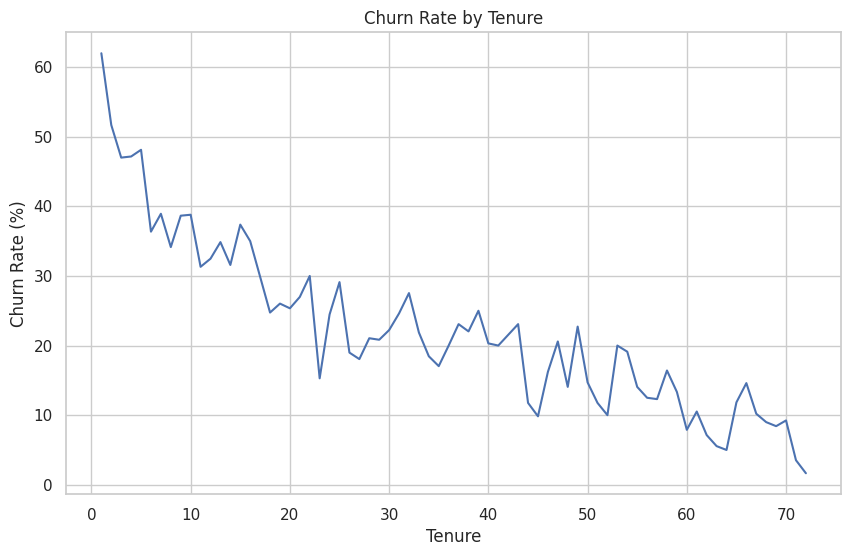

In [78]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=tenure_churn, x='tenure', y='ChurnRate')
plt.title("Churn Rate by Tenure")
plt.xlabel("Tenure")
plt.ylabel("Churn Rate (%)")
plt.show()


Generally the lower the tenure, the higher the churn rate. This confirms that early churns is a key issue.

In [79]:
gender_churn = df.groupby('gender', observed=False).agg(
    TotalCustomers=('Churn', 'count'),
    Churners=('Churn', lambda x: (x == 1).sum()),
).reset_index() 
gender_churn['ChurnRate'] = (gender_churn['Churners'] / gender_churn['TotalCustomers']) * 100
print("\nChurn by Gender:\n", gender_churn)


Churn by Gender:
    gender  TotalCustomers  Churners  ChurnRate
0  Female            3483       939  26.959518
1    Male            3549       930  26.204565


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


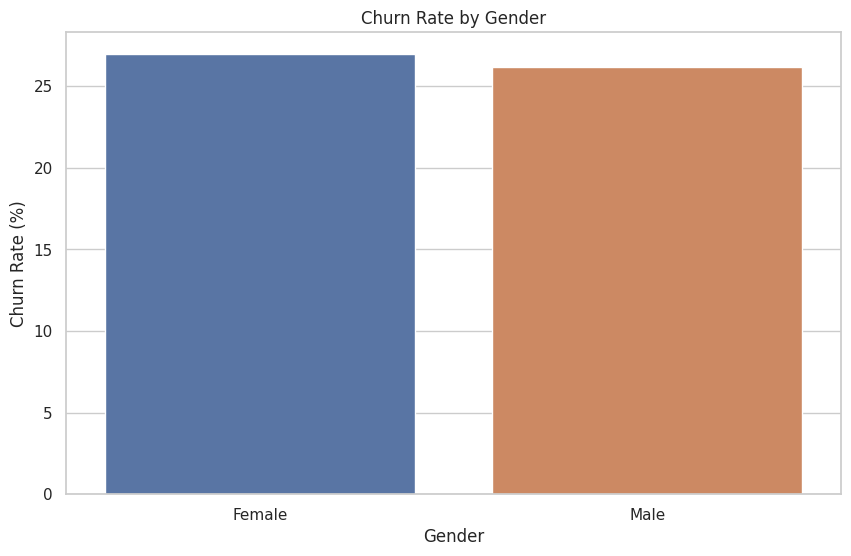

In [80]:
plt.figure(figsize=(10, 6))
sns.barplot(data=gender_churn, x='gender', y='ChurnRate')
plt.title("Churn Rate by Gender")
plt.xlabel("Gender")
plt.ylabel("Churn Rate (%)")
plt.show()

Both genders have very similar churn rates, which means the strategies 

In [81]:
senior_churn = df.groupby('SeniorCitizen', observed=False).agg(
    TotalCustomers=('Churn', 'count'),
    Churners=('Churn', lambda x: (x == 1).sum()),
).reset_index() 
senior_churn['ChurnRate'] = (senior_churn['Churners'] / senior_churn['TotalCustomers']) * 100
print("\nChurn by Senior Citizen Status:\n", senior_churn)


Churn by Senior Citizen Status:
    SeniorCitizen  TotalCustomers  Churners  ChurnRate
0          False            5890      1393  23.650255
1           True            1142       476  41.681261


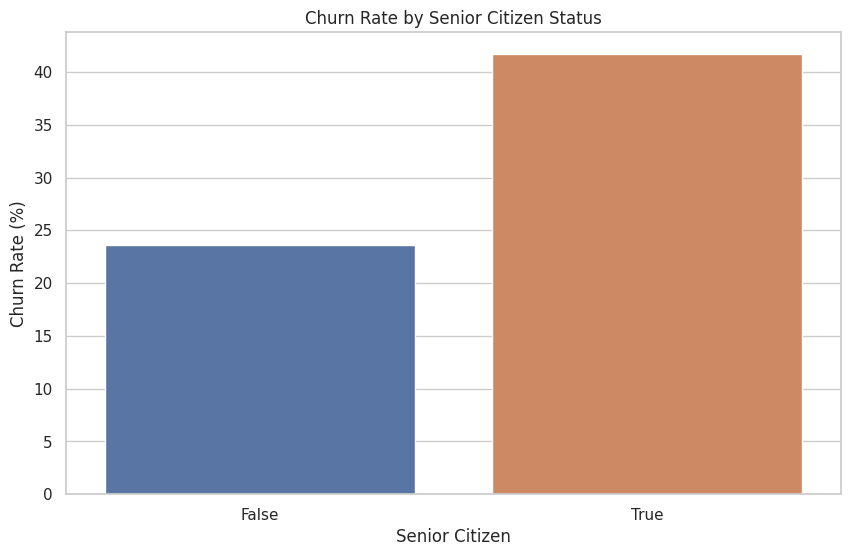

In [82]:
plt.figure(figsize=(10, 6))
sns.barplot(data=senior_churn, x='SeniorCitizen', y='ChurnRate')
plt.title("Churn Rate by Senior Citizen Status")
plt.xlabel("Senior Citizen")
plt.ylabel("Churn Rate (%)")
plt.show()

Senior citizens have a high churn rate compared to those who are specified as non-senior citizens (almost 2 times higher). Senior citizens may have higher churn due to different needs (e.g., preferring landlines).

**Actionable insights**: Offer senior discounts or special plans to reduce churn.

In [83]:
partner_churn = df.groupby('Partner', observed=False).agg(
    TotalCustomers=('Churn', 'count'),
    Churners=('Churn', lambda x: (x == 1).sum()),
).reset_index()
partner_churn['ChurnRate'] = (partner_churn['Churners'] / partner_churn['TotalCustomers']) * 100
print("\nChurn by Partner Status:\n", partner_churn)


Churn by Partner Status:
    Partner  TotalCustomers  Churners  ChurnRate
0    False            3639      1200  32.976092
1     True            3393       669  19.717065


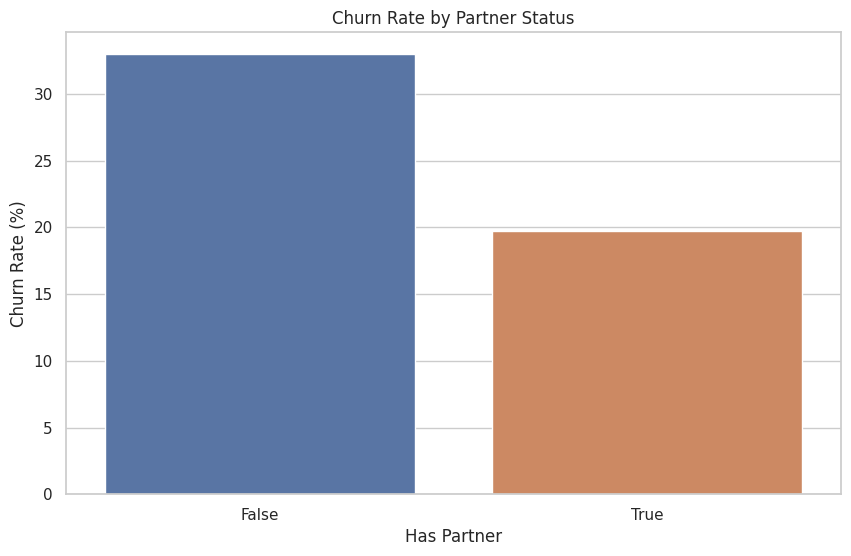

In [84]:
plt.figure(figsize=(10, 6))
sns.barplot(data=partner_churn, x='Partner', y='ChurnRate')
plt.title("Churn Rate by Partner Status")
plt.xlabel("Has Partner")
plt.ylabel("Churn Rate (%)")
plt.show()

In [85]:
dependents_churn = df.groupby('Dependents', observed=False).agg(
    TotalCustomers=('Churn', 'count'),
    Churners=('Churn', lambda x: (x == 1).sum()),
).reset_index()
dependents_churn['ChurnRate'] = (dependents_churn['Churners'] / dependents_churn['TotalCustomers']) * 100
print("\nChurn by Dependents Status:\n", dependents_churn)


Churn by Dependents Status:
    Dependents  TotalCustomers  Churners  ChurnRate
0       False            4933      1543  31.279140
1        True            2099       326  15.531205


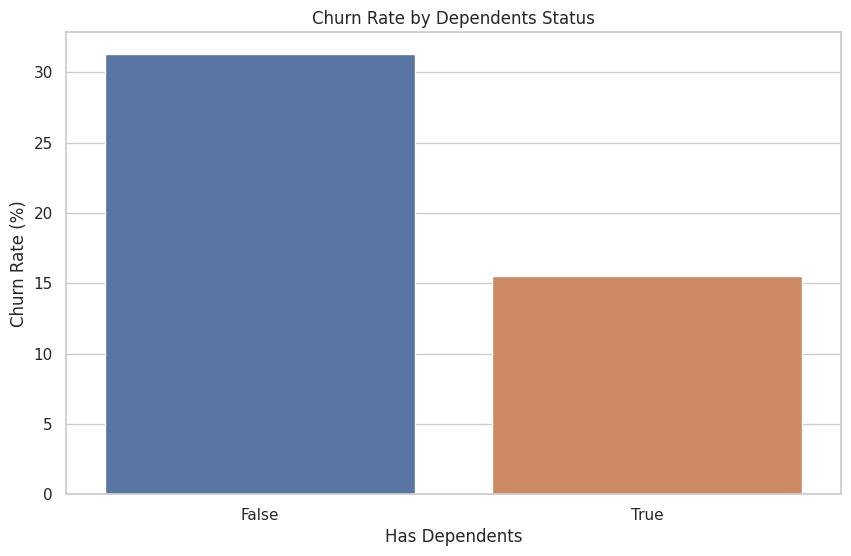

In [86]:
plt.figure(figsize=(10, 6))
sns.barplot(data=dependents_churn, x='Dependents', y='ChurnRate')
plt.title("Churn Rate by Dependents Status")
plt.xlabel("Has Dependents")
plt.ylabel("Churn Rate (%)")
plt.show()

Customers with partners/dependents churn almost half as much as those without. One possible reason is that they likely need stable service. 

**Actionable Insights**: Target customers without dependents with family plan promotions.

In [87]:
# Define MonthlyChargeCategory
def categorize_charges(charge):
    if charge < 41:
        return "Low"
    elif 41 <= charge <= 80:
        return "Medium"
    elif 81 <= charge <= 120:
        return "High"
    else:
        return "Very High"

# Apply category function
df["MonthlyChargeCategory"] = df["MonthlyCharges"].apply(categorize_charges)

# Group by relevant columns and calculate metrics
churn_summary = (
    df.groupby(["SeniorCitizen", "Partner", "Dependents", "MonthlyChargeCategory"], observed=False)
    .agg(CustomerCount=("Churn", "count"),
         Churners=("Churn", "sum"))
    .reset_index()
)

churn_summary["ChurnRate"] = (churn_summary["Churners"] / churn_summary["CustomerCount"]) * 100

# Sort by churn rate in descending order
churn_summary = churn_summary.sort_values(by="ChurnRate", ascending=False)
category_order = ["Low", "Medium", "High", "Very High"]
churn_summary['MonthlyChargeCategory'] = pd.Categorical(churn_summary['MonthlyChargeCategory'], categories=category_order, ordered=True)

print(churn_summary[['SeniorCitizen', 'Partner', 'Dependents', 'MonthlyChargeCategory', 'ChurnRate']])


    SeniorCitizen  Partner  Dependents MonthlyChargeCategory  ChurnRate
26           True     True       False             Very High  69.230769
16           True    False       False                  High  51.672862
21           True    False        True                Medium  50.000000
18           True    False       False                Medium  48.275862
3           False    False       False             Very High  46.875000
17           True    False       False                   Low  43.137255
0           False    False       False                  High  41.035857
23           True     True       False                  High  37.216828
2           False    False       False                Medium  35.009141
25           True     True       False                Medium  33.870968
4           False    False        True                  High  33.823529
19           True    False       False             Very High  33.333333
30           True     True        True             Very High  33

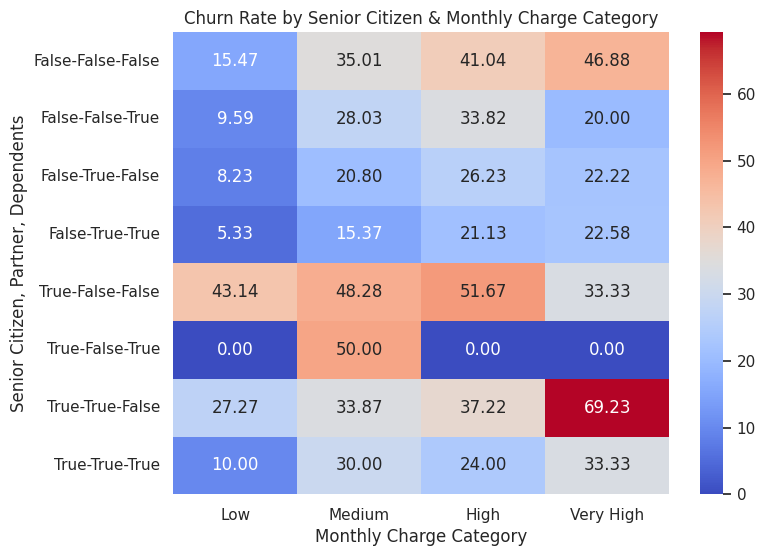

In [88]:
plt.figure(figsize=(8, 6))
sns.heatmap(churn_summary.pivot_table( index=['SeniorCitizen', 'Partner', 'Dependents'], columns='MonthlyChargeCategory', values='ChurnRate', observed=False).fillna(0), 
            cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Churn Rate by Senior Citizen & Monthly Charge Category")
plt.ylabel("Senior Citizen, Partner, Dependents")
plt.xlabel("Monthly Charge Category")
plt.show()

Senior citizens without a partner/dependents and with high monthly charges are the biggest churn risks. 

**Actionable Insights**: Offer discounts, personalized deals, or value-added services to high-spending customers to reduce churn risk. Encouraging partner/family engagement stabilizes retention. Promote family plans.

The False-True-True group (Not a Senior Citizen, Has Partner, Has Dependents) has the lowest churn rates across all charge levels. This might be because these customers have family commitments that tie them to the service.

**Actionable Insight**: Promote family plans and multi-user discounts to retain these customers long-term.


### Plan Demographic

In [89]:
# Group by relevant columns and calculate metrics
paymentMethod_churn = df.groupby('PaymentMethod', observed=False).agg(
    TotalCustomers=('Churn', 'count'),
    Churners=('Churn', lambda x: (x == 1).sum()),
).reset_index()
paymentMethod_churn['ChurnRate'] = (paymentMethod_churn['Churners'] / paymentMethod_churn['TotalCustomers']) * 100
print("\nChurn by Payment Method:\n", paymentMethod_churn)


Churn by Payment Method:
                PaymentMethod  TotalCustomers  Churners  ChurnRate
0  Bank transfer (automatic)            1542       258  16.731518
1    Credit card (automatic)            1521       232  15.253123
2           Electronic check            2365      1071  45.285412
3               Mailed check            1604       308  19.201995


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


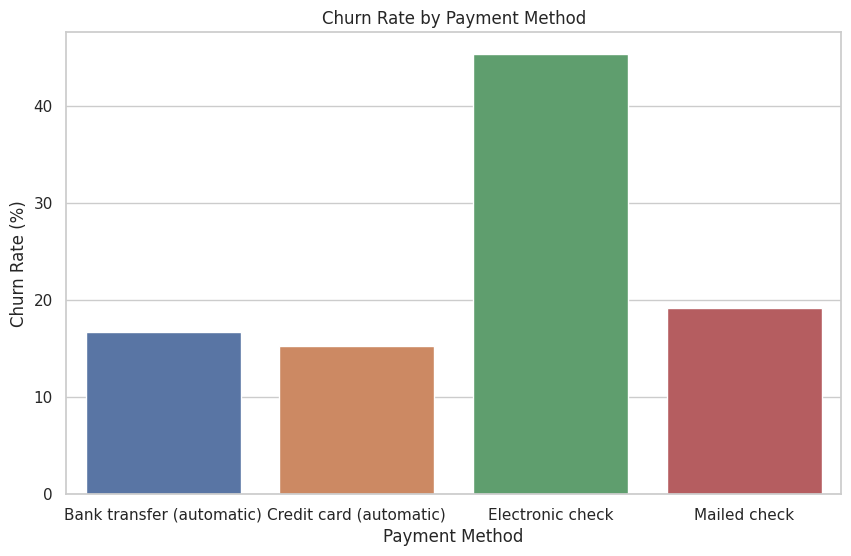

In [90]:
plt.figure(figsize=(10, 6))
sns.barplot(data=paymentMethod_churn, x='PaymentMethod', y='ChurnRate')
plt.title("Churn Rate by Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Churn Rate (%)")
plt.show()

Customers who pay with electronic check have the highest churn rate at 45.3% - double the rate for the remaining 3 payment methods, mailed check, bank transfer (automatic), and credit card (automatic). 

**Actionable Insights** : Find ways to encourage customers to choose automatic payment methods.

In [91]:
# Group by relevant columns and calculate metrics
contract_churn = df.groupby('Contract', observed=False).agg(
    TotalCustomers=('Churn', 'count'),
    Churners=('Churn', lambda x: (x == 1).sum()),
).reset_index()
contract_churn['ChurnRate'] = (contract_churn['Churners'] / contract_churn['TotalCustomers']) * 100
print("\nChurn by Contract:\n", contract_churn)


Churn by Contract:
          Contract  TotalCustomers  Churners  ChurnRate
0  Month-to-month            3875      1655  42.709677
1        One year            1472       166  11.277174
2        Two year            1685        48   2.848665


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


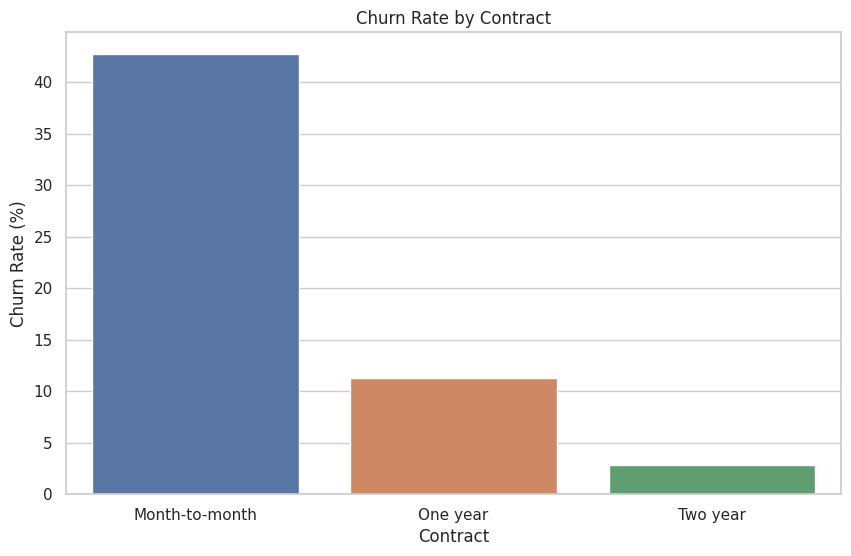

In [92]:
plt.figure(figsize=(10, 6))
sns.barplot(data=contract_churn, x='Contract', y='ChurnRate')
plt.title("Churn Rate by Contract")
plt.xlabel("Contract")
plt.ylabel("Churn Rate (%)")
plt.show()

Unsurprisingly, the shortest contract period, month-to-month is most common amongst churners. 

**Actionable Insight**: Offer attractive deals for longer term contracts to lock in customers and reduce churn rates.

In [93]:
# Creating bins for TotalCharges
df['TotalChargeCategory'] = pd.cut(df['TotalCharges'], bins=[0, 1000, 3000, 6000, df['TotalCharges'].max()],
                                   labels=['Low', 'Medium', 'High', 'Very High'])
totalcharge_tenure = df.groupby('TotalChargeCategory', observed=False).agg(
    CustomerCount=('TotalCharges', 'count'),
    AvgTenure=('tenure', 'mean'),
    Churners=("Churn", "sum")
)

# Calculating churn rate
totalcharge_tenure["ChurnRate"] = (totalcharge_tenure["Churners"] / totalcharge_tenure["CustomerCount"]) * 100
totalcharge_tenure = totalcharge_tenure.sort_values('ChurnRate', ascending=False)
print("\nTotal Charges vs Tenure:\n", totalcharge_tenure)


Total Charges vs Tenure:
                      CustomerCount  AvgTenure  Churners  ChurnRate
TotalChargeCategory                                               
Low                           2893  10.146906      1070  36.985828
Medium                        1935  36.366925       449  23.204134
High                          1512  53.742725       262  17.328042
Very High                      692  67.927746        88  12.716763


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


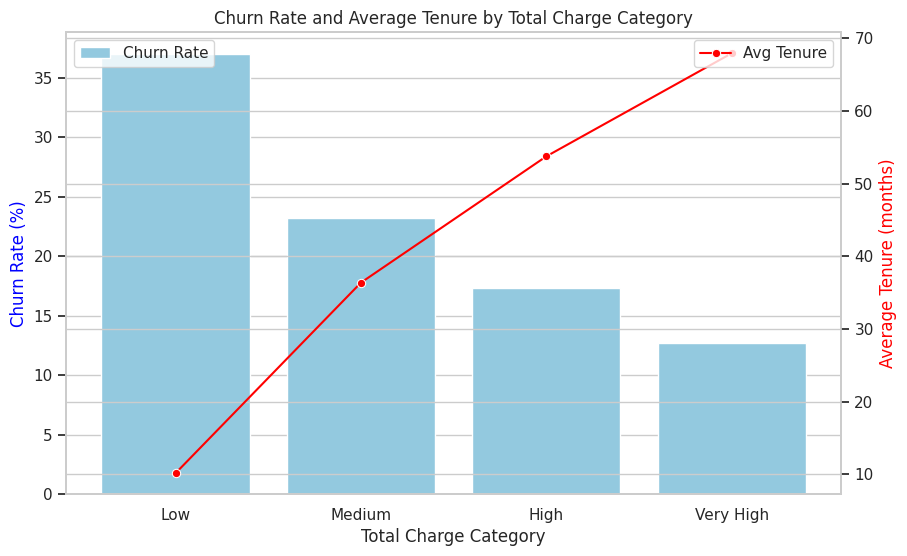

In [94]:
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(data=totalcharge_tenure.reset_index(), x='TotalChargeCategory', y='ChurnRate', ax=ax1, color='skyblue', label="Churn Rate")

# Create secondary axis for tenure
ax2 = ax1.twinx()
sns.lineplot(data=totalcharge_tenure.reset_index(), x='TotalChargeCategory', y='AvgTenure', ax=ax2, color='red', marker='o', label="Avg Tenure")

# Labels and titles
ax1.set_xlabel("Total Charge Category")
ax1.set_ylabel("Churn Rate (%)", color="blue")
ax2.set_ylabel("Average Tenure (months)", color="red")
plt.title("Churn Rate and Average Tenure by Total Charge Category")

# Add legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

A significant portion of customers (~37%) fall into the Low category and leave within a year. The Very High category has fewer customers (692) but stays the longest, making them valuable for long-term revenue. 

**Actionable Insights**: The company may need to analyze why early churn happens (e.g., pricing issues, service dissatisfaction). Retention efforts should focus on the Very High group.

In [95]:
# Creating bins for TenureCategory
df['TenureCategory'] = pd.cut(df['tenure'], bins=[0, 25, 50, df['tenure'].max()],
                              labels=['Low', 'Medium', 'High'])
tenure_category_churn = df.groupby('TenureCategory', observed=False).agg(
    AvgTenure=('tenure', 'mean'),
    Churners=('Churn', lambda x: (x == 1).sum()),
    CustomerCount=('Churn', 'count')  
).reset_index()

# Calculating churn rate
tenure_category_churn['ChurnRate'] = (tenure_category_churn['Churners'] / tenure_category_churn['CustomerCount']) * 100
tenure_category_churn = tenure_category_churn.sort_values('AvgTenure', ascending=False)
print("\nChurn Rate by Tenure Category:\n", tenure_category_churn)


Churn Rate by Tenure Category:
   TenureCategory  AvgTenure  Churners  CustomerCount  ChurnRate
2           High  63.910689       188           2105   8.931116
1         Medium  37.809582       327           1649  19.830200
0            Low   9.490543      1354           3278  41.305674


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


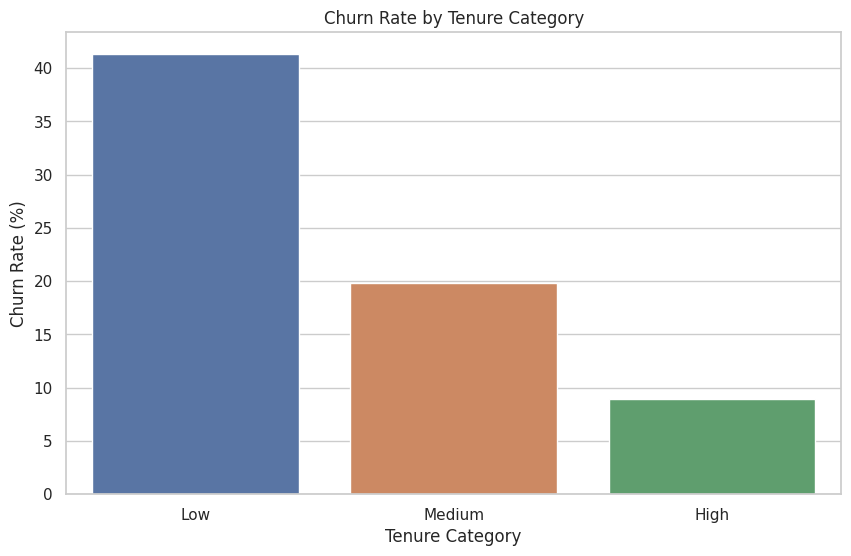

In [96]:
plt.figure(figsize=(10, 6))
sns.barplot(data=tenure_category_churn, x='TenureCategory', y='ChurnRate')
plt.title("Churn Rate by Tenure Category")
plt.xlabel("Tenure Category")
plt.ylabel("Churn Rate (%)")
plt.show()

The low tenure group (0 - 25 months) has the highest churn rate at 41.3% - meaning nearly half of these customers leave within two years. Churn rate drops to half that at 19.8% at the medium tenure group (26 - 50 months) and even more to 8.9% at the high tenure group (> 51 months)

**Actionable Insights**:
* Early-stage churn is the biggest issue. Since most churn happens within the first two years, focusing retention strategies on new customers is critical.
* New customer onboarding & engagement should be a priority. Offering discounts, better customer support, or loyalty incentives within the first year could reduce churn.


In [97]:
# Creating bins for MonthlyCharges
df['MonthlyChargeCategory'] = pd.cut(df['MonthlyCharges'], 
                                     bins=[0, 40, 80, df['MonthlyCharges'].max() + 1], 
                                     labels=['Low', 'Medium', 'High'])
monthlycharge_churn = df.groupby('MonthlyChargeCategory', observed=False).agg(
    CustomerCount=('MonthlyCharges', 'count'),
    Churners=('Churn', lambda x: (x == 1).sum()),
).reset_index()

# Calculating churn rate
monthlycharge_churn['ChurnRate'] = (monthlycharge_churn['Churners'] / monthlycharge_churn['CustomerCount']) * 100
monthlycharge_churn = monthlycharge_churn.sort_values('ChurnRate', ascending=False)
print("\nChurn by Monthly Charge Category:\n", monthlycharge_churn)


Churn by Monthly Charge Category:
   MonthlyChargeCategory  CustomerCount  Churners  ChurnRate
2                  High           2665       906  33.996248
1                Medium           2535       749  29.546351
0                   Low           1832       214  11.681223


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


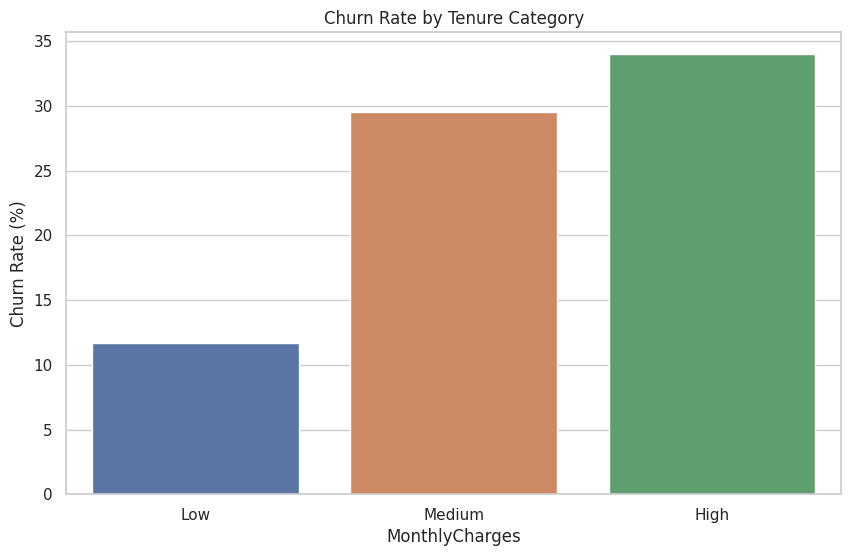

In [98]:
plt.figure(figsize=(10, 6))
sns.barplot(data=monthlycharge_churn, x='MonthlyChargeCategory', y='ChurnRate')
plt.title("Churn Rate by Tenure Category")
plt.xlabel("MonthlyCharges")
plt.ylabel("Churn Rate (%)")
plt.show()

The results indicate a strong correlation between higher monthly charges and increased churn rates.
Customers in the High Monthly Charge category (80+) churn at the highest rate of 34%. The Medium Monthly Charge group (40-80) follows closely with a 29.5% churn rate. In contrast, the Low Monthly Charge group (<40) has the lowest churn rate at only 11.7%, showing that low-cost customers are far more likely to stay.

Customers with higher bills may feel the financial strain, making them more likely to cancel services. If customers paying premium prices don't feel they're getting enough value, they might churn in favor of cheaper competitors.

**Actionable Insights**: 
* Focus on retention strategies for high-paying customers like loyalty discounts or bundled perks to make premium plans feel more valuable.
* Investigate low-charge customers. Are they getting fewer services or just better pricing?

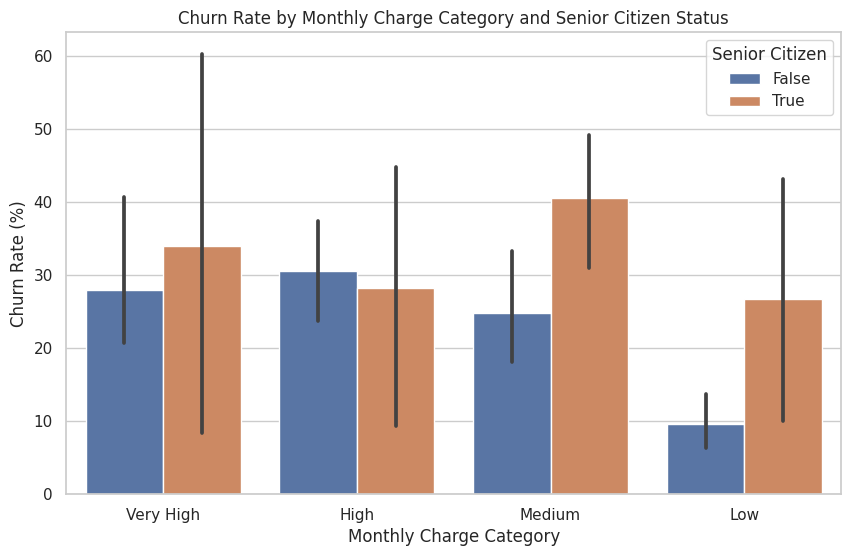

In [99]:
churn_summary['MonthlyChargeCategory'] = churn_summary['MonthlyChargeCategory'].astype(str)
plt.figure(figsize=(10, 6))
sns.barplot(data=churn_summary, x='MonthlyChargeCategory', y='ChurnRate', hue='SeniorCitizen')
plt.title("Churn Rate by Monthly Charge Category and Senior Citizen Status")
plt.xlabel("Monthly Charge Category")
plt.ylabel("Churn Rate (%)")
plt.legend(title="Senior Citizen")
plt.show()


Senior citizens have a higher churn rate in most categories. In every monthly charge category, the orange bars (Senior Citizens) tend to have a higher churn rate compared to non-Senior Citizens. This suggests that older customers are more likely to leave, possibly due to financial constraints, dissatisfaction, or difficulty using services.

**Actionable Insigts**: 
* Offer retention strategies like discounted bundles or loyalty programs for Medium Charge customers.
* Improve support and onboarding for older customers to increase satisfaction.

Medium charge customers (41-80 range) show the highest churn rate for Senior Citizens (~40%). This could indicate that this group feels like they’re overpaying for the value received.

**Actionable Insigts**:
* Conduct surveys to understand why Medium Charge customers churn the most.
* Consider offering discounts or adding more value (e.g., better service, more features) to this tier to retain customers

In [100]:
# Columns with services subscribed to 
features = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
service_churn = []

# Calculating churn rate for customers with each feature and without
for feature in features:
    churn_with_feature = df[df[feature] == 'Yes']['Churn'].mean() * 100
    churn_without_feature = df[df[feature] != 'Yes']['Churn'].mean() * 100
    service_churn.append([feature, churn_with_feature, churn_without_feature])

service_churn_df = pd.DataFrame(service_churn, columns=['Feature', 'ChurnRate_WithFeature', 'ChurnRate_WithoutFeature'])
service_churn_df = service_churn_df.sort_values('ChurnRate_WithFeature', ascending=False)
print("\nChurn by Service Usage:\n", service_churn_df)


Churn by Service Usage:
             Feature  ChurnRate_WithFeature  ChurnRate_WithoutFeature
4       StreamingTV              30.114687                 24.370524
5   StreamingMovies              29.952398                 24.436178
2  DeviceProtection              22.539289                 28.695275
1      OnlineBackup              21.567010                 29.216410
3       TechSupport              15.196078                 31.229968
0    OnlineSecurity              14.640199                 31.373331


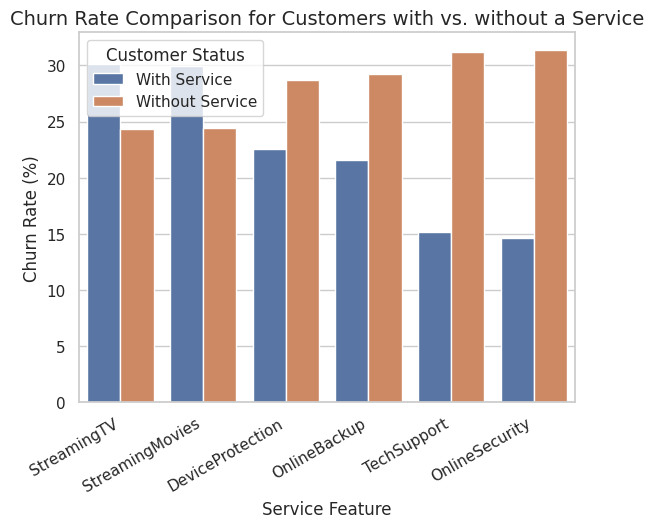

In [101]:
service_churn_df_melted = service_churn_df.melt(id_vars='Feature', 
                                                var_name='Service Status', 
                                                value_name='Churn Rate (%)')


# Rotate x-axis labels for readability
ax = sns.barplot(data=service_churn_df_melted, 
                 x='Feature', 
                 y='Churn Rate (%)', 
                 hue='Service Status')

# Rotate x-axis labels for readability
plt.xticks(rotation=30, ha='right')

plt.title("Churn Rate Comparison for Customers with vs. without a Service", fontsize=14)
plt.xlabel("Service Feature", fontsize=12)
plt.ylabel("Churn Rate (%)", fontsize=12)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["With Service", "Without Service"], title="Customer Status")

# Show plot
plt.show()

1. Streaming services correlate with higher churn. Customers with Streaming TV/Movies churn ~5.5% more than those without.
* Streaming services might be seen as optional add-ons that don’t increase customer stickiness. Customers might cancel when they find alternative platforms or better deals.
* **Actionable Insights**: Bundle streaming with contracts or offer retention deals.

2. Tech Support & Security drastically reduce churn. Churn drops from ~31% to ~15% with these services.
* These services increase customer reliance on the provider, making them less likely to switch.
* **Actionable Insights**: Upsell security & support services to at-risk customers.

3. Device Protection & Online Backup help reduce churn, but to a lesser extent. Churn drops by 6–7% for customers with these services.
* Customers with backup & protection services churn less, though the effect isn’t as strong as Tech Support/Security.
* **Actionable Insights**: Offer discounted first 3 months for these services to increase adoption.

## Predictive Model


### Data Preparation
Before I can train the model. I need to ensure a few things. There cannot be any null or blank values in the data. Then I must encode the categorical columns in the data. I will also need to remove highly correlated or redundant features to improve model efficiency such as the tenureCategory, MonthlyChargeCategory, as well as TotalChargeCategory. It is also best to normalize numerical features such as MonthlyCharges and TotalCharges.

In [102]:
print(df.isnull().sum())  # Shows count of NaNs in each column

customerID               0
gender                   0
SeniorCitizen            0
tenure                   0
MultipleLines            0
InternetService          0
OnlineSecurity           0
OnlineBackup             0
DeviceProtection         0
TechSupport              0
StreamingTV              0
StreamingMovies          0
Contract                 0
PaymentMethod            0
MonthlyCharges           0
TotalCharges             0
Partner                  0
Dependents               0
PhoneService             0
PaperlessBilling         0
Churn                    0
MonthlyChargeCategory    0
TotalChargeCategory      0
TenureCategory           0
dtype: int64


In [103]:
print(df.isna().sum())

customerID               0
gender                   0
SeniorCitizen            0
tenure                   0
MultipleLines            0
InternetService          0
OnlineSecurity           0
OnlineBackup             0
DeviceProtection         0
TechSupport              0
StreamingTV              0
StreamingMovies          0
Contract                 0
PaymentMethod            0
MonthlyCharges           0
TotalCharges             0
Partner                  0
Dependents               0
PhoneService             0
PaperlessBilling         0
Churn                    0
MonthlyChargeCategory    0
TotalChargeCategory      0
TenureCategory           0
dtype: int64


Encoding columns with OHE:

In [104]:
print(df['TotalCharges'].min())

18.799999237060547


In [105]:
df_encoded = pd.get_dummies(df, columns=["gender", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", 
                                         "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", 
                                         "Contract", "PaymentMethod"], drop_first=True)
print(df_encoded.columns)

Index(['customerID', 'SeniorCitizen', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'Partner', 'Dependents', 'PhoneService',
       'PaperlessBilling', 'Churn', 'MonthlyChargeCategory',
       'TotalChargeCategory', 'TenureCategory', 'gender_Male',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')


Normalize numerical features if needed (especially for models like Logistic Regression, SVM, etc.).

In [106]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_encoded[['MonthlyCharges', 'TotalCharges', 'Tenure']] = scaler.fit_transform(df[['MonthlyCharges', 'TotalCharges', 'tenure']])


Remove highly correlated or redundant features to improve model efficiency. We don't need to keep both the category columns and the actual columns so I will remove the category columns made for visualizations. I will also remove gender because it has little to no affect on churning and may contribute noise to the models.

In [107]:
df_encoded.drop(['MonthlyChargeCategory', 'TotalChargeCategory', 'TenureCategory', 'gender_Male'], axis='columns', inplace=True)

### Split Data

Now I will split the data into train and test data. The dataset is imbalanced with ~26.6% being true for Churn and the remaining being false. So I will use stratify.

In [108]:
df_encoded['Churn'].value_counts()

Churn
False    5163
True     1869
Name: count, dtype: int64

In [109]:
df_encoded.columns = df_encoded.columns.get_level_values(0)
print(df_encoded.columns)

Index(['customerID', 'SeniorCitizen', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'Partner', 'Dependents', 'PhoneService',
       'PaperlessBilling', 'Churn', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No internet service',
       'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Tenure'],
      dtype='object')


## Logistic Regression

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score


# Keep the original numerical features
feature_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Identify categorical columns based on the actual df_encoded column names
categorical_prefixes = ["gender", "MultipleLines", "InternetService", "OnlineSecurity",
                        "OnlineBackup", "DeviceProtection", "TechSupport", 
                        "StreamingTV", "StreamingMovies", "Contract", "PaymentMethod"]

encoded_categorical_cols = [col for col in df_encoded.columns if any(prefix in col for prefix in categorical_prefixes)]
feature_cols += encoded_categorical_cols

print(feature_cols)



['tenure', 'MonthlyCharges', 'TotalCharges', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']


In [111]:
def confMatrix(y_pred):
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    cnf_matrix
    class_names=[0,1]
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


In [112]:
from sklearn.metrics import classification_report

X = df_encoded[feature_cols]
y = df_encoded["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16, stratify=y)
logreg = LogisticRegression()

In [113]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_iter': [ 500, 1000, 1500],
    'random_state': [4, 8, 16, 32]
}

grid_search = GridSearchCV(logreg, param_grid, scoring='f1', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'max_iter': 500, 'random_state': 4}


              precision    recall  f1-score   support

       False       0.84      0.88      0.86      1033
        True       0.63      0.53      0.58       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407



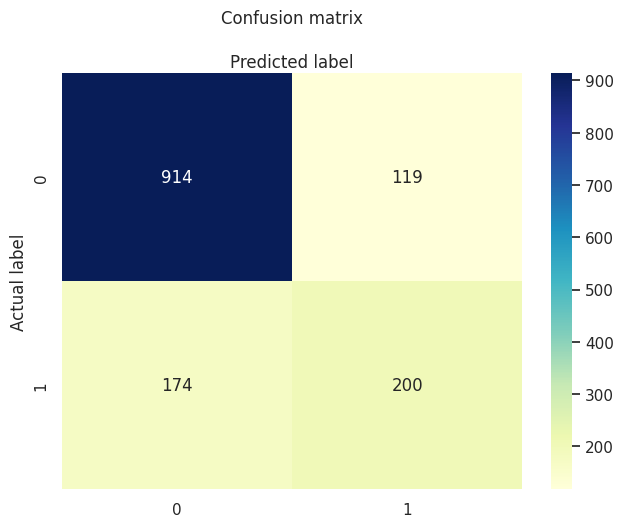

In [114]:
logreg = LogisticRegression(max_iter=500, random_state=4, )
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred))

confMatrix(y_pred)

The model has a 79% accuracy, but given the imbalance of churn vs no churn data in the dataset, just choosing no churn more often improves the accuracy score. Of all the predicted "churn" cases, 63% were correct. This means the model has many false positives. The model also only captures 52% of actual churn cases, meaning it's missing almost half of the real churners (false negatives). Churn prediction is complex and simple logistic regression might not capture deeper patterns in the data so I will try different models.

## Random Forest

In [115]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'class_weight': ['balanced', None],
    'random_state': [4, 8, 16, 32]
}
rf_model = RandomForestClassifier()  
grid = GridSearchCV(rf_model, param_grid, scoring='f1', cv=5)
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)

Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 100, 'random_state': 16}


              precision    recall  f1-score   support

       False       0.87      0.77      0.82      1033
        True       0.52      0.70      0.60       374

    accuracy                           0.75      1407
   macro avg       0.70      0.73      0.71      1407
weighted avg       0.78      0.75      0.76      1407



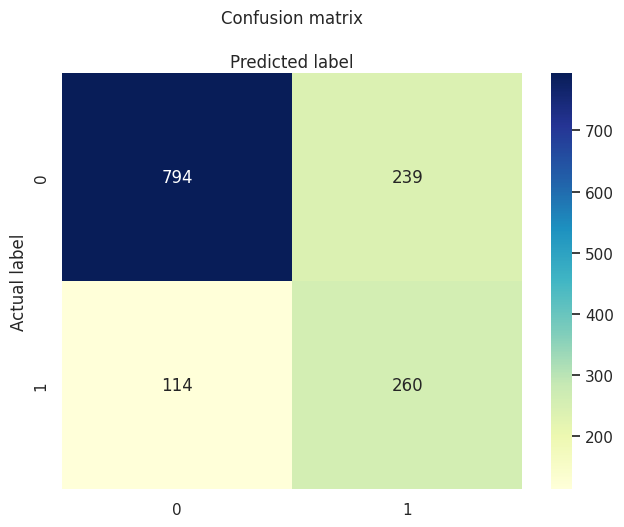

In [116]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100,
    max_depth=10,
    min_samples_split=10, 
    class_weight="balanced",
    random_state=16)  
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


print(classification_report(y_test, y_pred_rf))
confMatrix(y_pred_rf)

Of all the predicted "churn" cases, 53% were correct. This means the model has many false positives as seen in the confusion matrix. The model captures 70% of actual churn cases, which is an improvement from the linear regression model's 52%.

## SMOTE
Since only 26% of customers churn, the models are biased towards "no churn". I will try to mitigate this by oversampling the minority class (churners) using SMOTE. Synthetic Minority Over-sampling Technique (SMOTE) creates synthetic examples of churners to balance the dataset.

              precision    recall  f1-score   support

       False       0.89      0.78      0.83      1033
        True       0.54      0.73      0.62       374

    accuracy                           0.77      1407
   macro avg       0.72      0.75      0.73      1407
weighted avg       0.80      0.77      0.77      1407



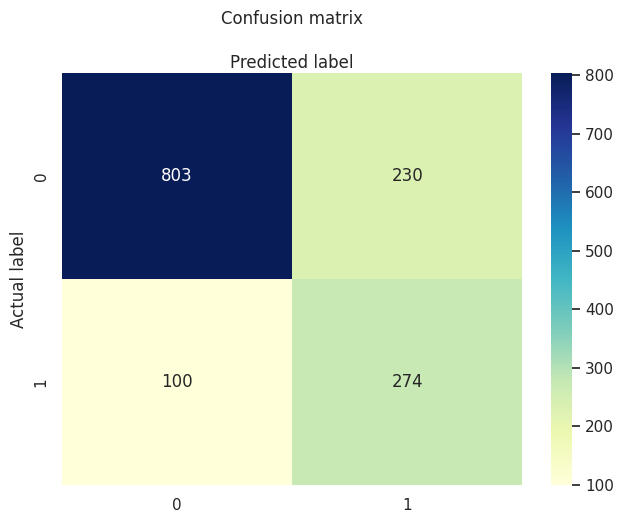

In [117]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=16)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

rf_model.fit(X_resampled, y_resampled) 
y_pred_rf_smote = rf_model.predict(X_test)

print(classification_report(y_test, y_pred_rf_smote))
confMatrix(y_pred_rf_smote)

I fit the Random Forest model to the SMOTE resampled data. There is not much improvement for precision in identifying churn cases - only 1%, but the recall improved by 3%. 

              precision    recall  f1-score   support

       False       0.88      0.76      0.82      1033
        True       0.52      0.71      0.60       374

    accuracy                           0.75      1407
   macro avg       0.70      0.74      0.71      1407
weighted avg       0.78      0.75      0.76      1407



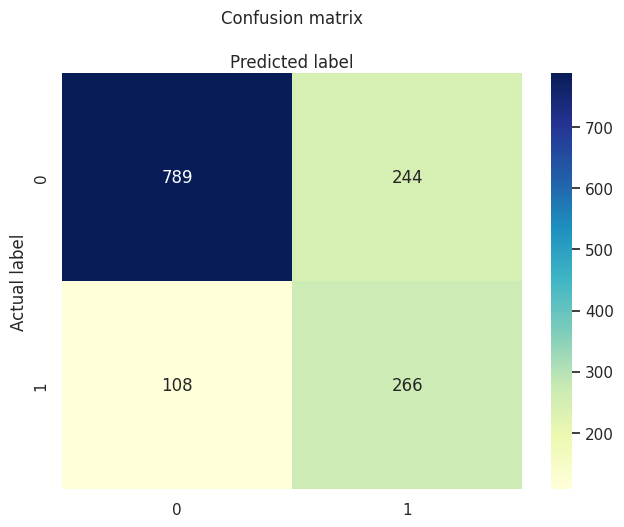

In [118]:
logreg.fit(X_resampled, y_resampled)
y_pred_logreg_smote = logreg.predict(X_test)

print(classification_report(y_test, y_pred_logreg_smote))
confMatrix(y_pred_logreg_smote)

There is significant improvement for recall for the logistic regression model, specifically ~14%. 
Of all the predicted "churn" cases, 54% were correct. This means the model still has many false positives, however the model now captures 66% of actual churn cases. While originally it only captured 52% of the actual churn cases.

## k-NN

Best KNN parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
              precision    recall  f1-score   support

       False       0.85      0.74      0.79      1033
        True       0.47      0.63      0.54       374

    accuracy                           0.71      1407
   macro avg       0.66      0.68      0.66      1407
weighted avg       0.75      0.71      0.72      1407



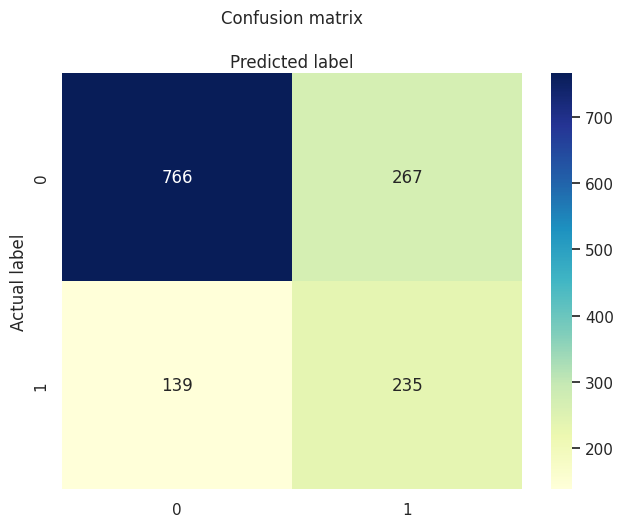

In [119]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()

# GridSearchCV
grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_knn.fit(X_resampled, y_resampled)

# Best estimator
best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

# Evaluation
print("Best KNN parameters:", grid_knn.best_params_)
print(classification_report(y_test, y_pred_knn))
confMatrix(y_pred_knn)

The k-NN model, has worse recall and precision for true churn cases.

## XGBoost

XGBoost handles class imbalances better and has a built-in imbalance handling with scale_pos_weight.

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'scale_pos_weight': 2}
              precision    recall  f1-score   support

       False       0.89      0.77      0.82      1033
        True       0.53      0.72      0.61       374

    accuracy                           0.76      1407
   macro avg       0.71      0.75      0.72      1407
weighted avg       0.79      0.76      0.77      1407



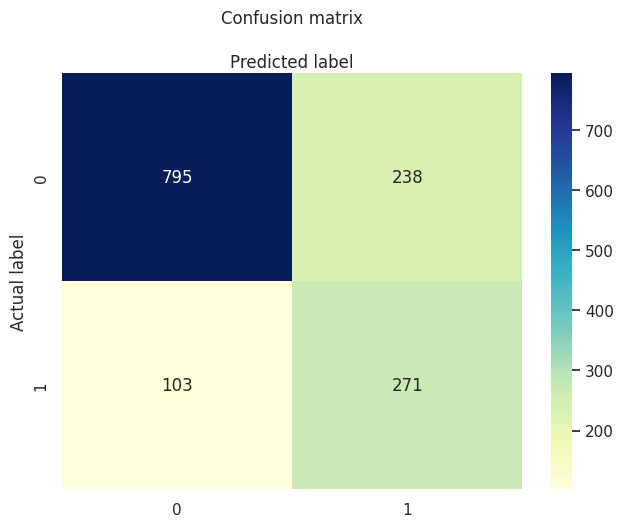

In [120]:
from xgboost import XGBClassifier

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 300, 500],
    'scale_pos_weight': [1, 1.5, 2]
}

xgb = XGBClassifier()
grid_search = GridSearchCV(xgb, param_grid, scoring='f1', cv=3, verbose=1)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

# Best estimator
best_xgb = grid_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print(classification_report(y_test, y_pred_xgb))
confMatrix(y_pred_xgb)

Without using the SMOTE sampling, XGBoost has better results than the linear regression model. However the recall for true churn cases still is not satisfactory. 

              precision    recall  f1-score   support

       False       0.94      0.58      0.72      1033
        True       0.44      0.90      0.59       374

    accuracy                           0.67      1407
   macro avg       0.69      0.74      0.65      1407
weighted avg       0.81      0.67      0.68      1407



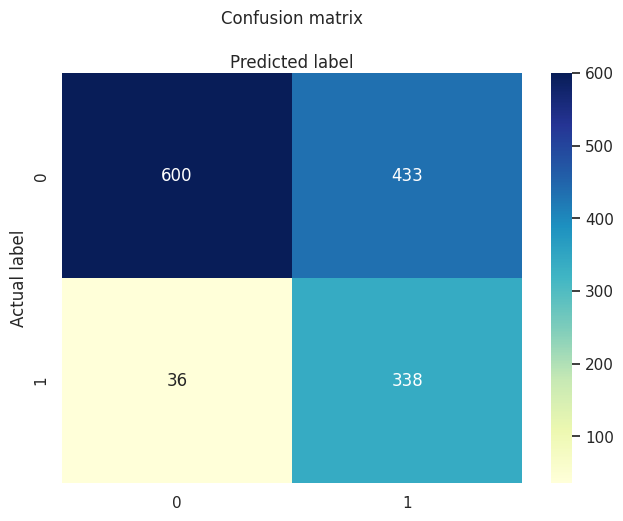

In [121]:
best_xgb.fit(X_resampled, y_resampled)
y_pred_xgb_smote = best_xgb.predict(X_test)

print(classification_report(y_test, y_pred_xgb_smote))
confMatrix(y_pred_xgb_smote)

With the SMOTE sampling, XGBoost has better capture rate for true churn cases, however there are more false positives. 

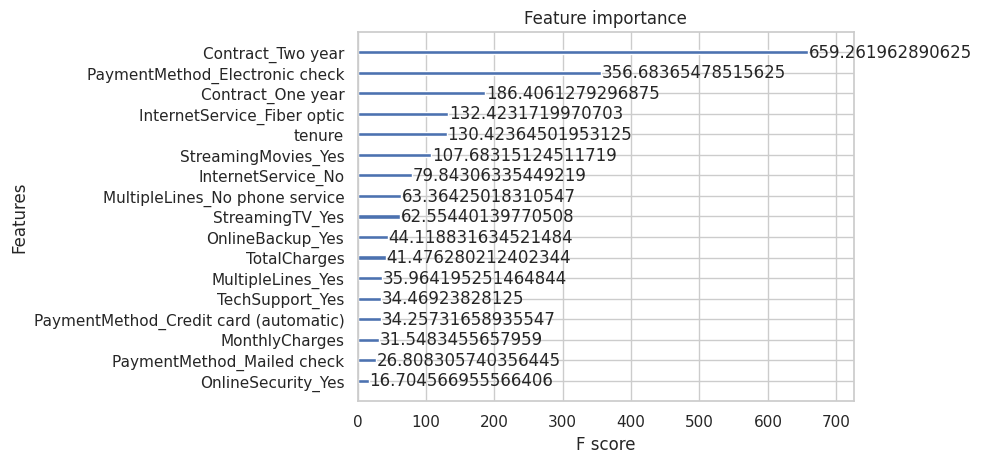

In [122]:
import xgboost as xgboost_module

xgboost_module.plot_importance(best_xgb, importance_type='gain')

plt.show()

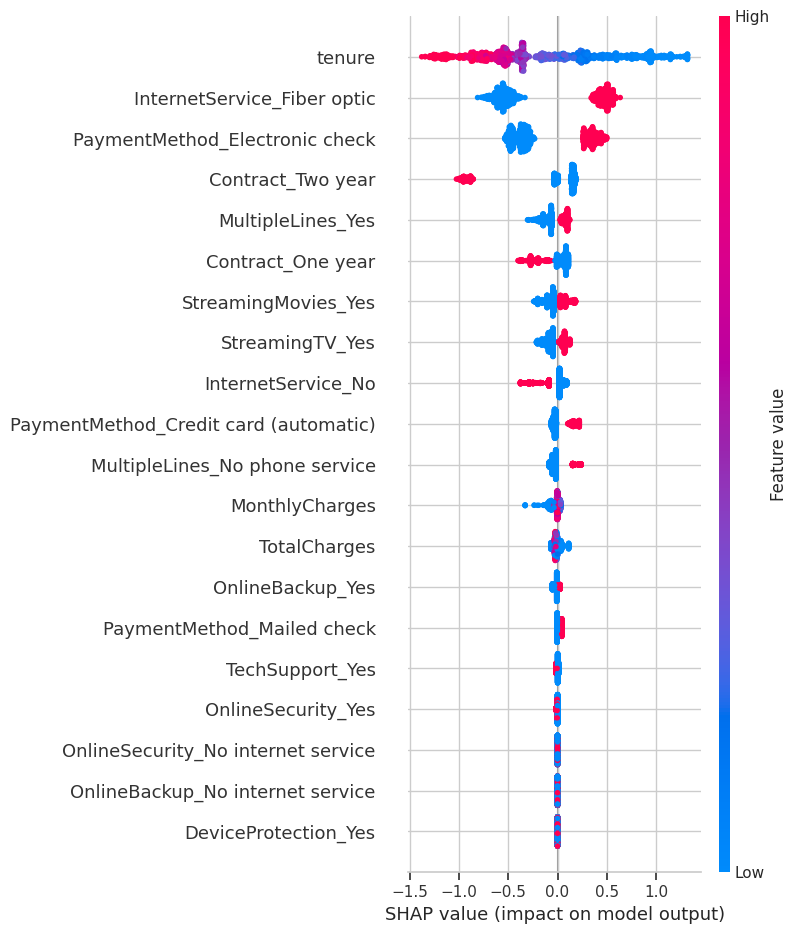

In [123]:
import shap

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

# Summary plot (global view)
shap.summary_plot(shap_values, X_test)

# Force plot for a single customer
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0])


I used both XGBoost’s built-in feature importance and SHAP values to understand what drives customer churn:

#### XGBoost's Feature Importance Plot
- Shows that **Contract_One year**, **Contract_Two year**, and **InternetService_Fiber optic** were frequently used in tree splits.
- **Tenure**, while still important, appears slightly lower here than in SHAP.
- This view reflects how often and effectively features are used, not necessarily their impact on individual predictions.
- 
#### SHAP Summary Plot (Model Interpretability)
- **Tenure** is the most impactful feature - customers with short tenure are more likely to churn.
- **Contract Type** also plays a major role:
  - Customers with **two-year contracts** are less likely to churn.
- **Fiber optic internet** is associated with higher churn.
- **Payment Method (Electronic check)** and **Online Security** also affect churn predictions.
- The SHAP summary plot provides **individual-level explanations**, considering feature interactions and actual impact on model output.

Plot importance tells you how useful a feature is for building the model.
SHAP tells you how much a feature actually influenced the predictions, including interactions and correlations.

## Model Comparison

In [124]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    'Logistic Regression': logreg,
    'Random Forest': rf_model,
    'XGBoost': best_xgb,
    'KNN': best_knn
}

# Function to calculate metrics
def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }

# Collect results
results = [evaluate_model(name, model) for name, model in models.items()]
comparison_df = pd.DataFrame(results)
comparison_df = comparison_df.sort_values(by='F1 Score', ascending=False)

comparison_df.style.set_caption("Model Performance Comparison")

,Model,Accuracy,Precision,Recall,F1 Score
1,Random Forest,0.765458,0.543651,0.732620,0.624146
0,Logistic Regression,0.749822,0.521569,0.711230,0.601810
2,XGBoost,0.666667,0.438392,0.903743,0.590393
3,KNN,0.711443,0.468127,0.628342,0.536530


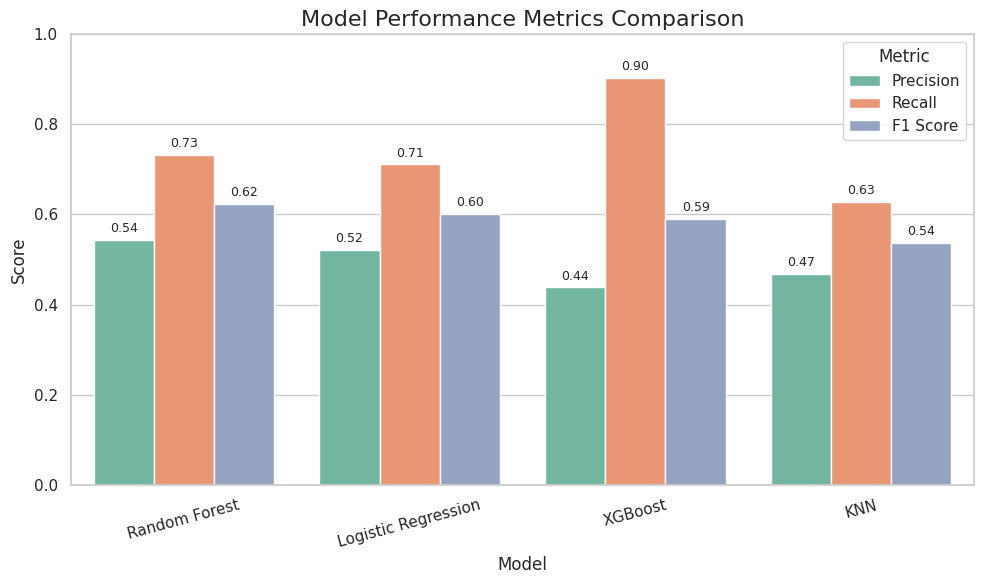

In [125]:
melted_df = comparison_df.melt(id_vars='Model', 
                                value_vars=['Precision', 'Recall', 'F1 Score'],
                                var_name='Metric',
                                value_name='Score')


plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

barplot = sns.barplot(data=melted_df, x='Model', y='Score', hue='Metric', palette='Set2')


for p in barplot.patches:
    barplot.annotate(f"{p.get_height():.2f}",
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     fontsize=9,
                     xytext=(0, 8),
                     textcoords='offset points')

plt.title('Model Performance Metrics Comparison', fontsize=16)
plt.ylabel('Score')
plt.ylim(0, 1.0)
plt.xticks(rotation=15)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

The Random Forest model outperforms others with the highest F1 Score (0.62) and Recall (0.73), making it the most suitable for churn prediction where capturing potential churners is a priority. Random Forest can flag about 3 out of every 4 customers who might churn. That gives the marketing or retention team a chance to act: offer discounts, personalized support, etc. A precision of (~ 54%) means some resources may be spent on non-churners, but that's often acceptable in churn prediction where missing a churner costs more. While precision is moderate, the business benefit of identifying churners early outweighs the cost of some false positives. 

XGBoost is a close second, offering competitive results with the added advantage of higer recall, better interpretability and performance for future deployment. XGBoost allows us to understand not just which features influence churn, but also how they do so - both across the entire dataset and for individual customers. This transparency enables data-driven strategies to reduce churn, such as focusing on customers with short tenure or month-to-month contracts.


## Conclusion

In this Telco customer churn analysis project, I aimed to identify key drivers of churn and build predictive models to help the business proactively address customer attrition. Several classification models were evaluated, with the Random Forest and XGBoost models achieving the highest performance, particularly in terms of F1 Score and Recall — crucial metrics when the goal is to correctly identify customers who are likely to churn.

### Key Findings
Using XGBoost feature importance ane SHAP (SHapley Additive exPlanations), I identified the most influential features contributing to customer churn:
* **Tenure**: Customers with shorter tenure are far more likely to churn, indicating that the first few months are critical to customer retention.

* **Contract Type**: Month-to-month contracts are strongly associated with churn, while long-term contracts (one or two years) significantly reduce churn likelihood.

* **Internet Service - Fiber Optic**: Users with fiber optic internet show higher churn risk, possibly due to pricing or reliability issues.

* **Electronic Check Payment**: Customers using electronic check payments are more prone to churn, which may be a proxy for lower satisfaction or less engaged users.

* **Tech Support & Online Security**: Customers who have opted into tech support and security services tend to stay longer, suggesting these add-ons improve customer loyalty.

Notably, while XGBoost’s built-in feature importance highlighted contract types as the most important features, SHAP analysis emphasized tenure and internet service more prominently. This reflects a difference in global vs. local interpretability: XGBoost gives a broader average importance across trees, while SHAP captures how features influence individual customer decisions.

### Business Recommendations
Based on my findings, here are strategic actions the company can take to reduce churn:
1. **Early Retention Campaigns**
Focus retention efforts on new customers, especially within the first 2 years. Consider onboarding incentives, personalized check-ins, or loyalty points.

2. **Encourage Long-Term Contracts**
Promote 1 and 2-year contracts with appealing discounts or bundles to lock in customers and lower churn.


3. **Encourage Partner/Family Engagement**
Offer discounts, personalized deals, or value-added services to high-spending customers to reduce churn risk. Encouraging partner/family engagement stabilizes retention. Promote family plans and multi-user discounts to retain these customers long-term.

4. **Monitor High-Risk Payment Methods**
Track customers using electronic check payments more closely and consider targeted offers or satisfaction surveys to understand their disengagement.

5. **Offer Value-Add Services**
Encourage customers to subscribe to Tech Support and Online Security services, possibly bundling them into attractive packages to increase stickiness. Bundle streaming services into existing plans.

6. **Review Fiber Optic Service Experience**
Investigate potential issues with fiber optic plans - such as pricing, outages, or customer support - and address them to improve satisfaction.

## Final Thoughts
By integrating machine learning with interpretability techniques like SHAP, we not only predicted churn with reasonable accuracy but also uncovered actionable insights that can directly influence customer retention strategy. Future work can focus on deeper segmentation (e.g., by region or age group), time series analysis for churn prediction over time, and testing the impact of targeted interventions.